<div align="center">

# Exercise Sheet 3: Data Science Methods  
## Technische Universität München 
### Winter semester 2024-2025

</div>


In [18]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt

## 1. Exercise: Nelder-Mead Simplex Algorithm
### 1.1  Implement the Nelder-Mead Simplex Algorithm presented in the lecture, i.e. write a function in Python that minimizes a function passed as an argument. This function should return at least the minimum, the value of the minimized function at the minimum and the number of iterations needed to find it.

In [19]:
def Nelder_Mead_Simplex(f, initial_simplex, tol=1e-6, alpha=1, gamma=2, rho=0.5, sigma=0.5, imax=1000, show_all=False):
    initial_simplex = np.array(initial_simplex, dtype=float)
    n = initial_simplex.shape[1]
    if initial_simplex.shape != (n+1, n):
        raise ValueError(f'initial_simplex has an invalid shape: {initial_simplex.shape}. Expected: {(n+1, n)}.')
    rank = np.linalg.matrix_rank(initial_simplex)
    if rank < n:
        raise ValueError("The initial points in initial_simplex are linearly dependent.")

    f_vec = np.apply_along_axis(f, 1, initial_simplex)
    idx_sort = np.argsort(f_vec, kind='stable')
    simplex = initial_simplex[idx_sort]
    f_vec = f_vec[idx_sort]
    x_best_list = [simplex[0]]
    f_best_list = [f_vec[0]]
    i = 0
    per = np.sqrt((np.diff(simplex, axis=0)**2).sum(axis=1)).sum()/(n+1) # This is just a sort of perimeter of the simplex
    if per <= tol:
        print("Warning: initial_simplex was chosen to be so small, that no iteration was completed. Make this better")
    while per > tol and i < imax:
        f_new = None
        x_avg = simplex[:-1].mean(axis=0)
        xr = x_avg + alpha*(x_avg - simplex[-1])
        fr = f(xr)
        f_best = f_vec[0]
        f_worst = f_vec[-1] 
        f_2worst = f_vec[-2] 
        if fr < f_best:
            xe = x_avg + gamma*(xr - x_avg)
            fe = f(xe)
            if fe < fr:
                x_new = xe
                f_new = fe
            else:
                x_new = xr
                f_new = fr         
        elif fr < f_2worst:
            x_new = xr
            f_new = fr
        else:
            if fr < f_worst:
                xc = x_avg + rho*(xr - x_avg)
            else:
                xc = x_avg + rho*(simplex[-1] - x_avg)
            fc = f(xc)
            if fc < np.min([fr, f_worst]):
                x_new = xc
                f_new = fc
        if f_new is None:
            simplex = simplex[0] + sigma*(simplex - simplex[0])
            f_vec = np.apply_along_axis(f, 1, simplex)
        else:
            simplex[-1] = x_new
            f_vec[-1] = f_new
        idx_sort = np.argsort(f_vec, kind='stable')
        simplex = simplex[idx_sort]
        f_vec = f_vec[idx_sort]
        x_best_list.append(simplex[0])
        f_best_list.append(f_vec[0])
        per = np.sqrt((np.diff(simplex, axis=0)**2).sum(axis=1)).sum()/(n+1)
        i += 1
    n_round = int(-np.min([np.log10(tol).round(), -1]) - 1) 
    result = {
        "success" : per<tol,
        "f_min" : f_vec[0].round(n_round),
        "x" : simplex[0].round(n_round),
        "iterations" : i
    }
    if show_all:
        return result, x_best_list, f_best_list
    else:
        return result

### 1.2 Minimize with your self-made function the Rosenbrock function
### $$f(x, y) = \left(a - x\right)^2 + b \left(y - x^2\right)^2,$$
### for  \(a = 1\) and \(b = 100\). Furthermore, minimize
### $$g(x, y) = \left|x - 10\right| + \left|y + 1\right|.$$

In [20]:
Nelder_Mead_Simplex(sp.optimize.rosen, [[100, 2], [3, 30], [21, 0]])

{'success': True, 'f_min': 0.0, 'x': array([1., 1.]), 'iterations': 142}

In [21]:
g = lambda x : np.abs(x[0]-10) + np.abs(x[1]+1)

Nelder_Mead_Simplex(g, [[100, 2], [3, 30], [21, 0]])

{'success': True, 'f_min': 0.0, 'x': array([10., -1.]), 'iterations': 66}

### 1.3 Now minimize the functions above with the built-in `scipy.optimize.minimize` with the option `method=’Nelder-Mead’`. Measure the time it takes for both your minimizer and `minimize` from `scipy` to find the minimum of the Rosenbrock function. Also, how many iterations were needed?

In [22]:
%timeit Nelder_Mead_Simplex(sp.optimize.rosen, [[5, 5], [3, 30], [21, 0]])
%timeit sp.optimize.minimize(sp.optimize.rosen, [5, 5], method='Nelder-Mead')

10.6 ms ± 235 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
7.03 ms ± 1.92 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


## 2. Exercise: Hypothesis Testing

### 2.1 Determine the distributions of these statistics via Monte Carlo sampling with respect to the null hypothesis $P(T_i|H_0)$ and to the alternative hypothesis $P(T_i|H_1)$.

In [23]:
# Define the hypotheses
mu0 = [0., 0.]
cov0 = [[1, 0.5], [0.5, 1]]  
mu1 = [2, 0.]
cov1 = [[0.2, 0.2], [0.2, 1]]

# Define the test statistics
T1 = lambda x : x[0]
T2 = lambda x : x[1]
T3 = lambda x : x[0]**2 + x[1]**2
T4 = lambda x : np.exp(x[0]/2) - x[1] 

# Generate random samples from each hypothesis
n_sample = 5000
sample_H0 = np.random.multivariate_normal(mu0, cov0, n_sample)
sample_H1 = np.random.multivariate_normal(mu1, cov1, n_sample)

# Compute samples distributed according to P(T|H0) by applying T to the sample generated by H0
T1_sampleH0 = np.apply_along_axis(T1, axis=1, arr=sample_H0)
T2_sampleH0 = np.apply_along_axis(T2, axis=1, arr=sample_H0)
T3_sampleH0 = np.apply_along_axis(T3, axis=1, arr=sample_H0)
T4_sampleH0 = np.apply_along_axis(T4, axis=1, arr=sample_H0)

# Compute samples distributed according to P(T|H1) by applying T to the sample generated by H1
T1_sampleH1 = np.apply_along_axis(T1, axis=1, arr=sample_H1)
T2_sampleH1 = np.apply_along_axis(T2, axis=1, arr=sample_H1)
T3_sampleH1 = np.apply_along_axis(T3, axis=1, arr=sample_H1)
T4_sampleH1 = np.apply_along_axis(T4, axis=1, arr=sample_H1)

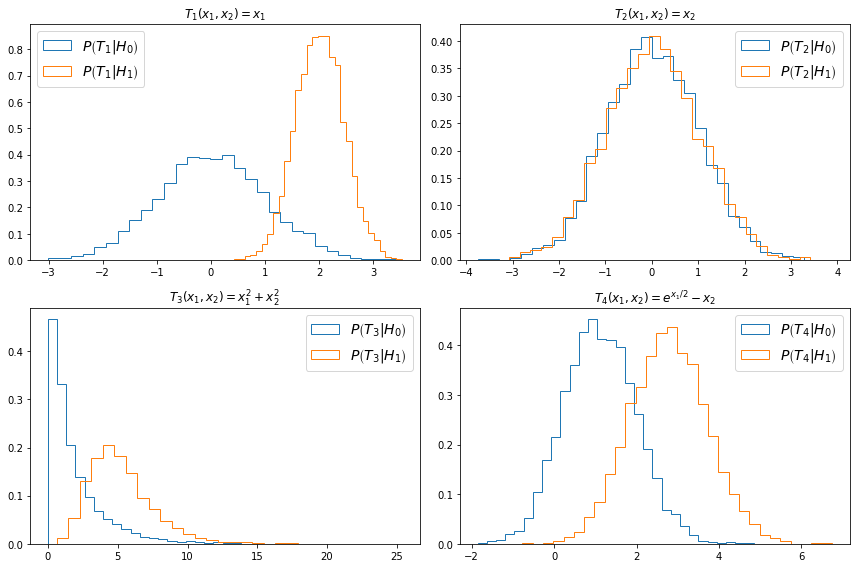

In [24]:
# We now plot these samples as histograms to visualize P(T|H0) and P(T|H1)
n_bins = 30
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

axes[0, 0].hist(T1_sampleH0, bins=n_bins, density=True, histtype='step', label=r'$P\left(T_1 | H_0\right)$')
axes[0, 0].hist(T1_sampleH1, bins=n_bins, density=True, histtype='step', label=r'$P\left(T_1 | H_1\right)$')
axes[0, 0].legend(fontsize=14)
axes[0, 0].set_title('$T_1(x_1, x_2) = x_1$')

axes[0, 1].hist(T2_sampleH0, bins=n_bins, density=True, histtype='step', label=r'$P\left(T_2 | H_0\right)$')
axes[0, 1].hist(T2_sampleH1, bins=n_bins, density=True, histtype='step', label=r'$P\left(T_2 | H_1\right)$')
axes[0, 1].legend(fontsize=14)
axes[0, 1].set_title('$T_2(x_1, x_2) = x_2$')

axes[1, 0].hist(T3_sampleH0, bins=n_bins, density=True, histtype='step', label=r'$P\left(T_3 | H_0\right)$')
axes[1, 0].hist(T3_sampleH1, bins=n_bins, density=True, histtype='step', label=r'$P\left(T_3 | H_1\right)$')
axes[1, 0].legend(fontsize=14)
axes[1, 0].set_title('$T_3(x_1, x_2) = x_1^2 + x_2^2$')

axes[1, 1].hist(T4_sampleH0, bins=n_bins, density=True, histtype='step', label=r'$P\left(T_4 | H_0\right)$')
axes[1, 1].hist(T4_sampleH1, bins=n_bins, density=True, histtype='step', label=r'$P\left(T_4 | H_1\right)$')
axes[1, 1].legend(fontsize=14)
axes[1, 1].set_title('$T_4(x_1, x_2) = e^{x_1/2} - x_2$')

plt.tight_layout()
plt.show()

### 2.2 Using your calculated $P(T_i|H_0)$ and $P(T_i|H_1)$, construct a ROC-curve.

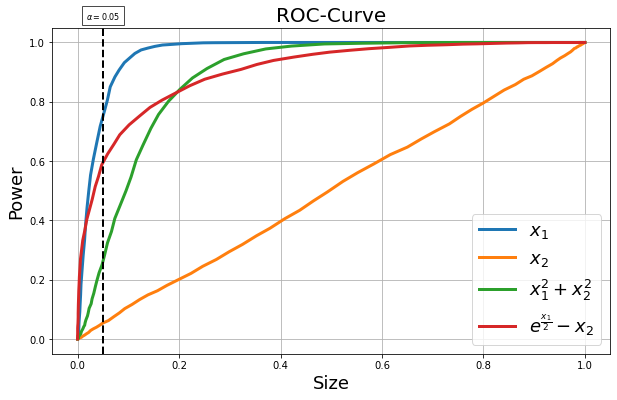

In [25]:
def integrate_tail_MCsample(t0, T_sampleH, tail='right'):
    if tail == 'left':
        return np.mean(T_sampleH <= t0)
    elif tail == 'right':
        return np.mean(T_sampleH > t0)
    else:
        raise ValueError(f"Invalid input for 'tail': {tail}. Allowed are 'right' and 'left'.")

def generate_ROC(T, T_sampleH0, T_sampleH1, tail='right', n_ROC=100):
    min_T_sampleH0, max_T_sampleH0 = np.min(T_sampleH0), np.max(T_sampleH0)
    min_T_sampleH1, max_T_sampleH1 = np.min(T_sampleH1), np.max(T_sampleH1)
    t0_list = np.linspace(np.min([min_T_sampleH0, min_T_sampleH1]), np.max([max_T_sampleH0, max_T_sampleH1]), n_ROC)
    size  = [integrate_tail_MCsample(t0, T_sampleH0, tail=tail) for t0 in t0_list]
    power = [integrate_tail_MCsample(t0, T_sampleH1, tail=tail) for t0 in t0_list]
    return size, power

# Now plot the ROC-curve
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

size1, power1 = generate_ROC(T1, T1_sampleH0, T1_sampleH1)
ax.plot(size1, power1, label=r"$x_1$", lw=3)
size2, power2 = generate_ROC(T2, T2_sampleH0, T2_sampleH1)
ax.plot(size2, power2, label=r"$x_2$", lw=3)
size3, power3 = generate_ROC(T3, T3_sampleH0, T3_sampleH1)
ax.plot(size3, power3, label=r"$x_1^2 + x_2^2$", lw=3)
size4, power4 = generate_ROC(T4, T4_sampleH0, T4_sampleH1)
ax.plot(size4, power4, label=r"$e^{\frac{x_1}{2}} - x_2$", lw=3)

# Add a vetical line at size = 0.05
ax.axvline(x=0.05, color='k', linestyle='--', linewidth=2)
# Add a text box near the vertical line
ax.text(0.05, 1.09, r'$\alpha = 0.05$', color='black', fontsize=8,
        verticalalignment='center', horizontalalignment='center', bbox=dict(facecolor='white', alpha=0.7))

plt.legend(fontsize=18)
plt.xlabel("Size", size=18)
plt.ylabel("Power", size=18)
plt.title(r"ROC-Curve", size=20)
plt.grid(True)
plt.show()

### Extra: Let us illustrate the statistics above in the hypotheses parameter space. Furthermore, we will consider more test statistics, including some complicated and arbitrary as well as the optimal (Neyman-Pearson lemma) likelihood ratio test statistic.

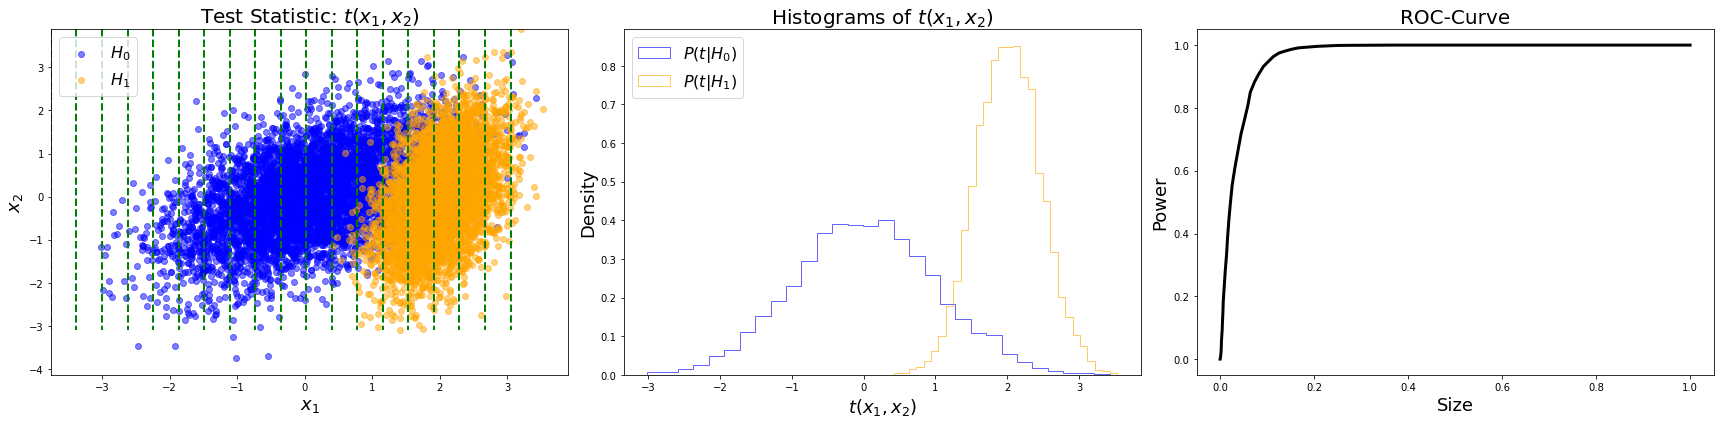

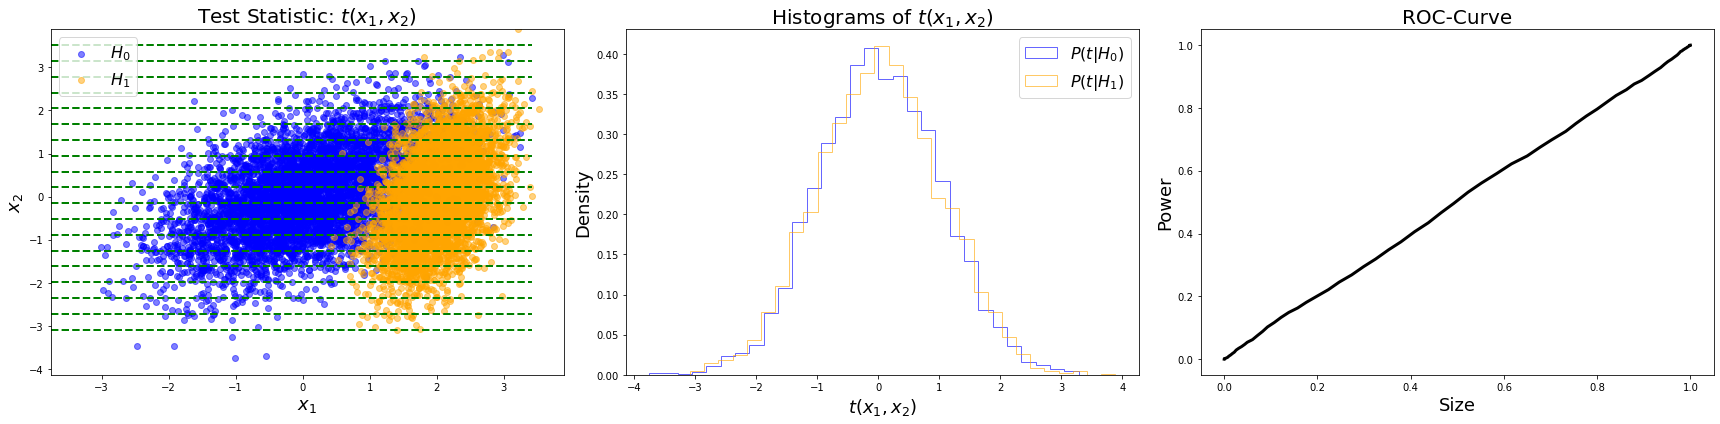

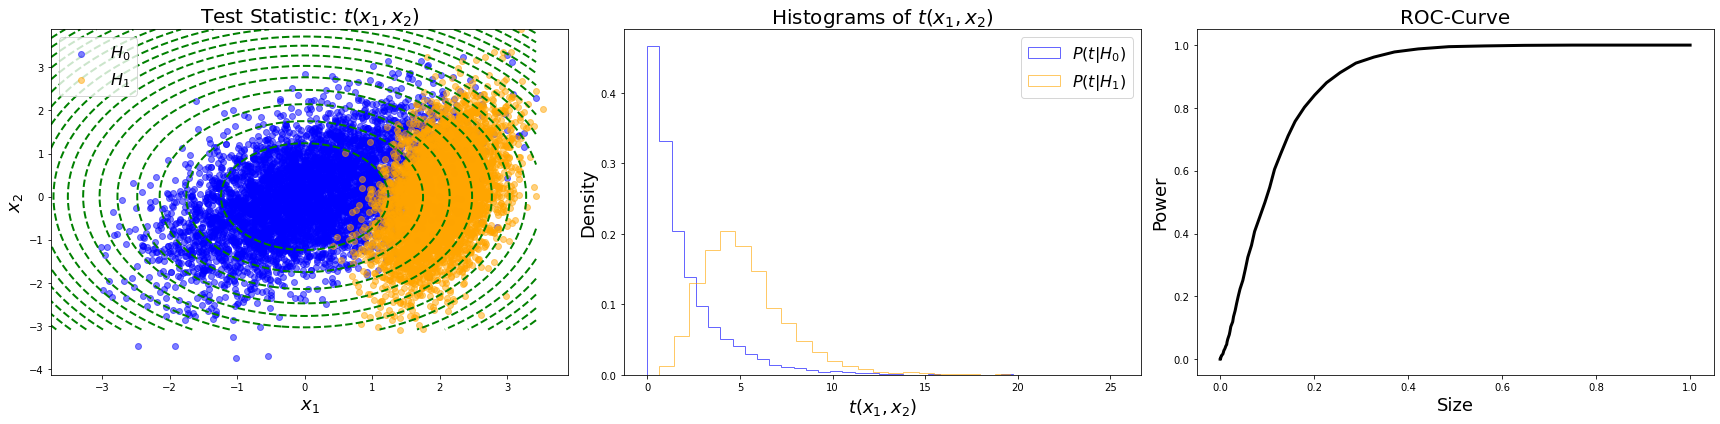

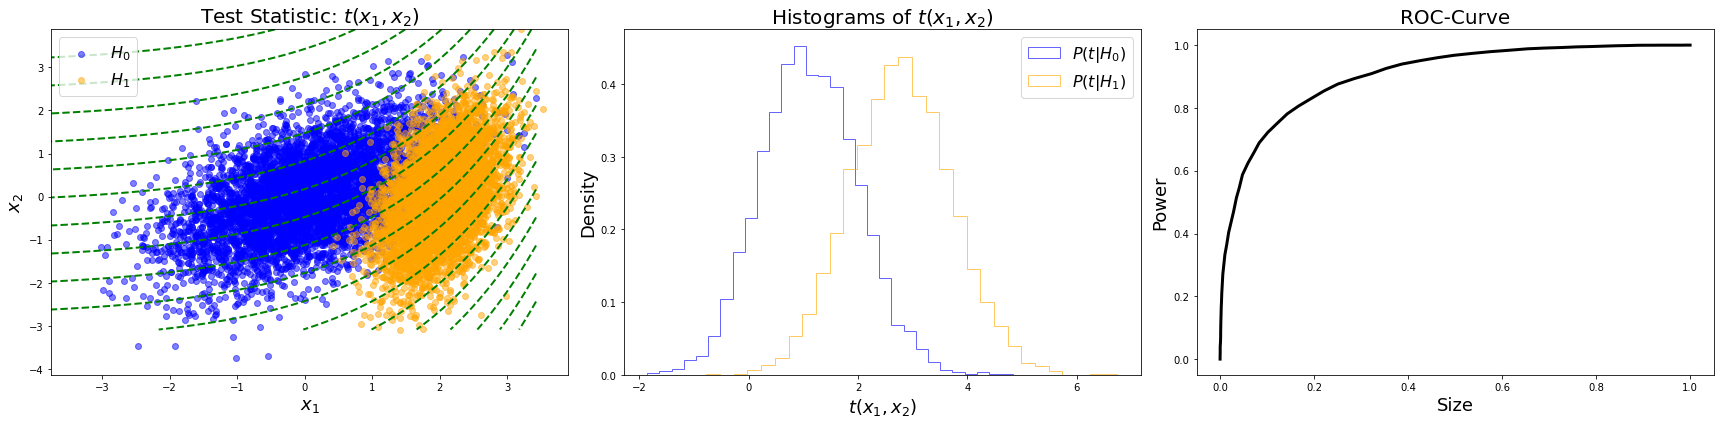

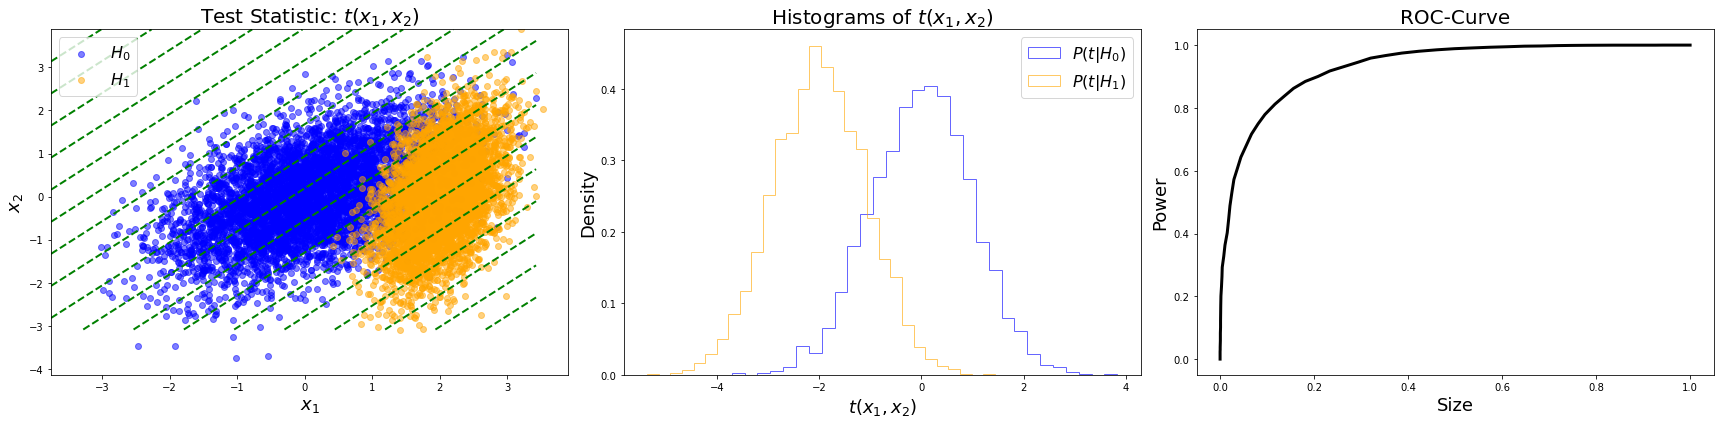

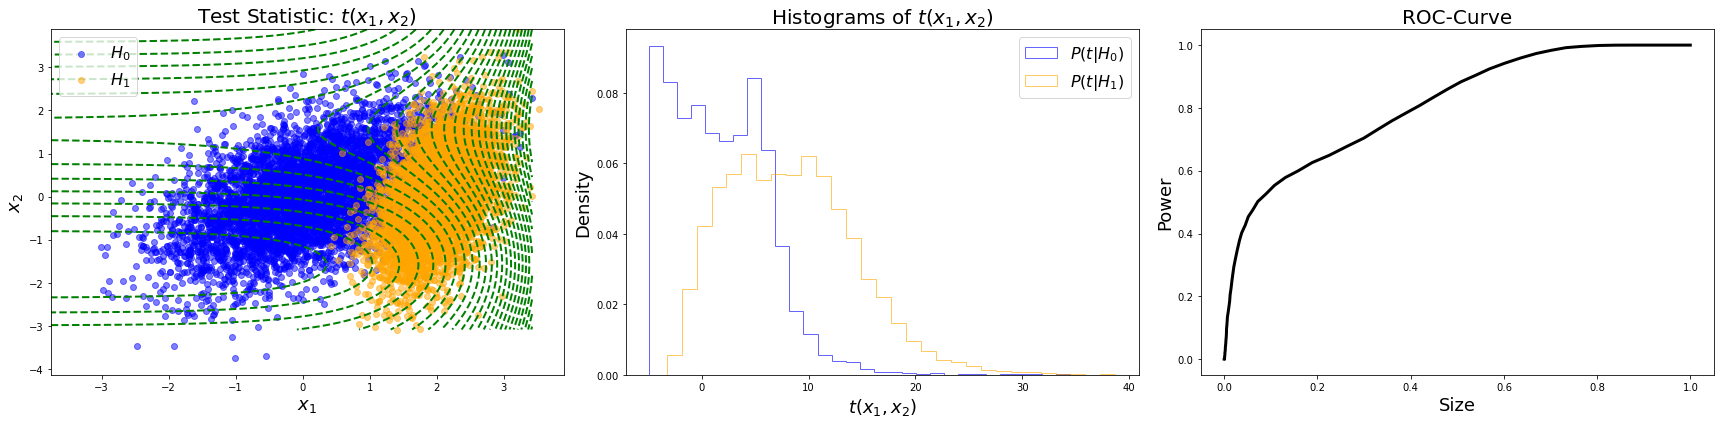

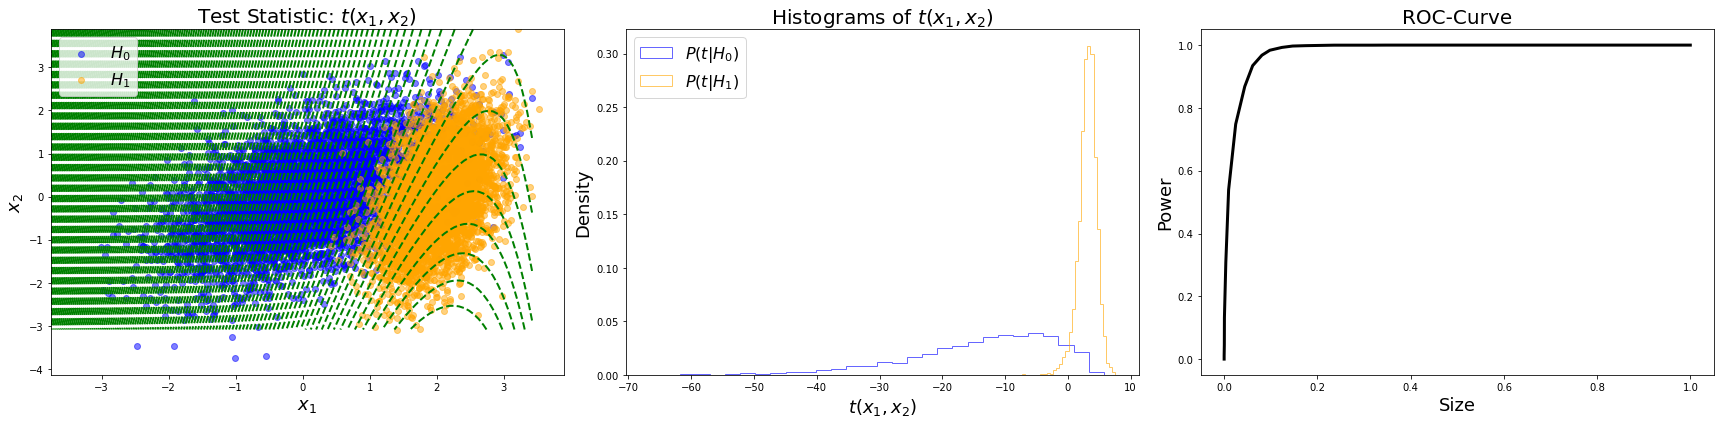

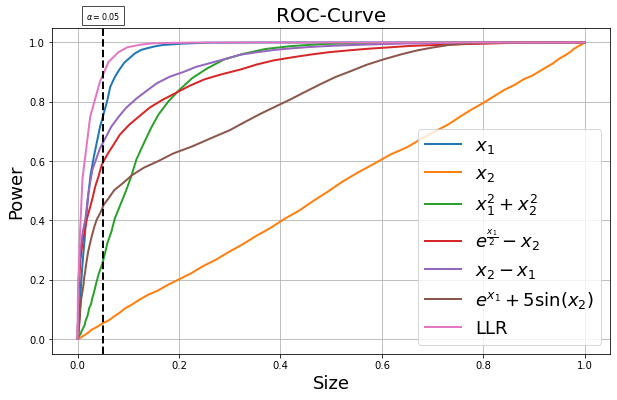

In [26]:

# Define the multivariate normal PDF function manually, such that broadcasting works
def multivariate_normal_pdf(x, mean, cov):
    mean = np.atleast_1d(mean)
    cov = np.atleast_2d(cov)
    k = mean.size  # Dimensionality
    cov_det = np.linalg.det(cov)
    cov_inv = np.linalg.inv(cov)
    norm_factor = 1.0 / (np.sqrt((2 * np.pi) ** k * cov_det))
    diff = x - mean
    exponent = -0.5 * np.einsum('...i,ij,...j->...', diff, cov_inv, diff)  # Exponent term with broadcasting
    return norm_factor * np.exp(exponent)

# Define the likelihood ratio function to handle arrays
def likelihood_ratio(X1, X2, mu1, mu2, cov1, cov2):
    # Stack X1 and X2 to create an array of shape (..., 2)
    points = np.stack((X1, X2), axis=-1)
    pdf_h1 = multivariate_normal_pdf(points, mean=mu2, cov=cov2)
    pdf_h0 = multivariate_normal_pdf(points, mean=mu1, cov=cov1)
    return np.log(pdf_h1 / pdf_h0)

def test_stat_analyze_2d(T, sample_H0, sample_H1, tail='right', n_ROC=100, n_contours=20):
    
    T_sampleH0 = np.apply_along_axis(T, axis=1, arr=sample_H0)
    T_sampleH1 = np.apply_along_axis(T, axis=1, arr=sample_H1)
    
    # Create a figure with 3 subplots (side by side)
    fig, axes = plt.subplots(1, 3, figsize=(24, 6))

    # First subplot: Scatter plot with contours
    ax1 = axes[0]
    ax1.scatter(sample_H0[:, 0], sample_H0[:, 1], color='blue', alpha=0.5, label=r"$H_0$", marker='o')
    ax1.scatter(sample_H1[:, 0], sample_H1[:, 1], color='orange', alpha=0.5, label=r"$H_1$", marker='o')

    min0, max0 = np.min(sample_H0), np.max(sample_H0)
    min1, max1 = np.min(sample_H1), np.max(sample_H1)

    # Create a grid of x and y values
    n_grid = 100
    x1 = np.linspace(min0, max0, n_grid)
    x2 = np.linspace(min1, max1, n_grid)
    X = np.meshgrid(x1, x2)

    S = T(X)

    # Plot isocurves of the sum S = t(X1, X2)
    contour_levels = np.linspace(np.min(S), np.max(S), n_contours)  # Define levels for the isocurves
    ax1.contour(X[0], X[1], S, levels=contour_levels, colors='green', linestyles='--', linewidths=2)

    # Set labels and title for the first subplot
    ax1.set_xlabel(r"$x_1$", size=18)
    ax1.set_ylabel(r"$x_2$", size=18)
    ax1.set_title("Test Statistic: $t(x_1, x_2)$", size=20)
    ax1.legend(fontsize=16)

    # Second subplot: Histograms of t(x_1, x_2)
    ax2 = axes[1]
    ax2.hist(T_sampleH0, bins=30, density=True, alpha=0.6, label=r"$P(t|H_0)$", color='blue', histtype="step")
    ax2.hist(T_sampleH1, bins=30, density=True, alpha=0.6, label=r"$P(t|H_1)$", color='orange', histtype="step")

    # Set labels and title for the second subplot
    ax2.set_xlabel(r"$t(x_1, x_2)$", size=18)
    ax2.set_ylabel(r"Density", size=18)
    ax2.set_title("Histograms of $t(x_1, x_2)$", size=20)
    ax2.legend(fontsize=16)

    size, power = generate_ROC(T, T_sampleH0, T_sampleH1, tail=tail)
    # Plot X vs Y in the third subplot
    ax3 = axes[2]
    ax3.plot(size, power, color='k', lw=3)
    ax3.set_xlabel("Size", size=18)
    ax3.set_ylabel("Power", size=18)
    ax3.set_title(r"ROC-Curve", size=20)

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()
    
T5 = lambda X : X[1] - X[0]
T6 = lambda X : np.exp(X[0]) + 5*np.sin(X[1])
T7 = lambda X : likelihood_ratio(X[0], X[1], mu0, mu1, cov0, cov1) # LLR

# Compute samples distributed according to P(T|H0) by applying T to the sample generated by H0
T5_sampleH0 = np.apply_along_axis(T5, axis=1, arr=sample_H0)
T6_sampleH0 = np.apply_along_axis(T6, axis=1, arr=sample_H0)
T7_sampleH0 = np.apply_along_axis(T7, axis=1, arr=sample_H0)

# Compute samples distributed according to P(T|H1) by applying T to the sample generated by H1
T5_sampleH1 = np.apply_along_axis(T5, axis=1, arr=sample_H1)
T6_sampleH1 = np.apply_along_axis(T6, axis=1, arr=sample_H1)
T7_sampleH1 = np.apply_along_axis(T7, axis=1, arr=sample_H1)

test_stat_analyze_2d(T1, sample_H0, sample_H1)
test_stat_analyze_2d(T2, sample_H0, sample_H1)
test_stat_analyze_2d(T3, sample_H0, sample_H1)
test_stat_analyze_2d(T4, sample_H0, sample_H1)
test_stat_analyze_2d(T5, sample_H0, sample_H1, tail='left')
test_stat_analyze_2d(T6, sample_H0, sample_H1, n_contours=30)
test_stat_analyze_2d(T7, sample_H0, sample_H1, n_ROC=10_000, n_contours=150)

# Now plot the ROC-curve
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

size1, power1 = generate_ROC(T1, T1_sampleH0, T1_sampleH1)
ax.plot(size1, power1, label=r"$x_1$", lw=2)
size2, power2 = generate_ROC(T2, T2_sampleH0, T2_sampleH1)
ax.plot(size2, power2, label=r"$x_2$", lw=2)
size3, power3 = generate_ROC(T3, T3_sampleH0, T3_sampleH1)
ax.plot(size3, power3, label=r"$x_1^2 + x_2^2$", lw=2)
size4, power4 = generate_ROC(T4, T4_sampleH0, T4_sampleH1)
ax.plot(size4, power4, label=r"$e^{\frac{x_1}{2}} - x_2$", lw=2)
size5, power5 = generate_ROC(T5, T5_sampleH0, T5_sampleH1, tail='left')
ax.plot(size5, power5, label=r"$x_2 - x_1$", lw=2)
size6, power6 = generate_ROC(T6, T6_sampleH0, T6_sampleH1)
ax.plot(size6, power6, label=r"$e^{x_1} + 5 \sin(x_2)$", lw=2)
size7, power7 = generate_ROC(T7, T7_sampleH0, T7_sampleH1)
ax.plot(size7, power7, label=r"LLR", lw=2)

# Add a vetical line at size = 0.05
ax.axvline(x=0.05, color='k', linestyle='--', linewidth=2)
# Add a text box near the vertical line
ax.text(0.05, 1.09, r'$\alpha = 0.05$', color='black', fontsize=8,
        verticalalignment='center', horizontalalignment='center', bbox=dict(facecolor='white', alpha=0.7))

plt.legend(fontsize=18)
plt.xlabel("Size", size=18)
plt.ylabel("Power", size=18)
plt.title(r"ROC-Curve", size=20)
plt.grid(True)
plt.show()

### 2.3 For a fixed size of $α = 0.05$, what is the best statistic? For this statistic, what would be the cutoff value $t_0$ delimiting the rejection and acceptance region?

t0 = 1.699, for alpha = 0.05.


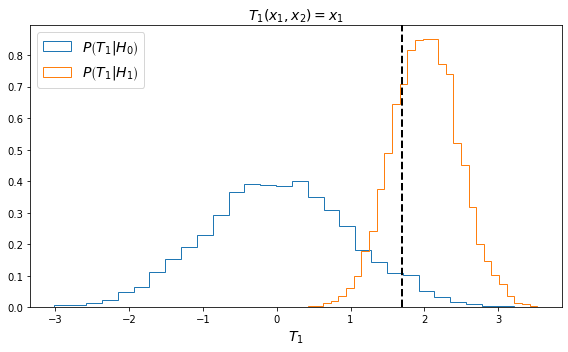

In [27]:
# From the plot above it is clear that T1 has the greatest power for size=0.05.
# Therefore, T1 is the best statistic among these.

# Define a function to yield the cutoff t0 from a fixed size
def get_t0_from_size(size, T, T_sampleH0, tail="right", n=5000):
    min_T_sampleH0, max_T_sampleH0 = np.min(T_sampleH0), np.max(T_sampleH0)
    t0_list = np.linspace(min_T_sampleH0, max_T_sampleH0, n)
    size_list  = np.array([integrate_tail_MCsample(t0, T_sampleH0, tail=tail) for t0 in t0_list])
    obj = abs(size_list - size)
    idxmin = np.argmin(obj)
    t0 = t0_list[idxmin]
    return t0

alpha = 0.05
t0 = get_t0_from_size(alpha, T1, T1_sampleH0)
print(rf"t0 = {t0.round(3)}, for alpha = {alpha}.")

n_bins = 30
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

ax.hist(T1_sampleH0, bins=n_bins, density=True, histtype='step', label=r'$P\left(T_1 | H_0\right)$')
ax.hist(T1_sampleH1, bins=n_bins, density=True, histtype='step', label=r'$P\left(T_1 | H_1\right)$')
ax.legend(fontsize=14)
ax.set_xlabel('$T_1$', fontsize=14)
ax.set_title('$T_1(x_1, x_2) = x_1$', fontsize=14)
ax.axvline(t0, color='k', linestyle='--', linewidth=2)

plt.tight_layout()
plt.show()

### 2.4 Write a function in Python that computes the p-value for an observation $X = (x_1, x_2)$. What is the p-value of $X = (2, 1)$ for each statistic $T_1, T_2, T_3, T_4$?

In [28]:
def p_value(T, X, T_sampleH0, tail="right"):
    t0 = T(X)
    p = integrate_tail_MCsample(t0, T_sampleH0, tail=tail)
    return p

X = (2, 1)
p_value(T1, X, T1_sampleH0), p_value(T2, X, T2_sampleH0), p_value(T3, X, T3_sampleH0), p_value(T4, X, T4_sampleH0)

(0.023, 0.1624, 0.0898, 0.2466)

### 2.5 Choose your favorite statistic and plot the distribution of the p-value under both $H_0$ and $H_1$.

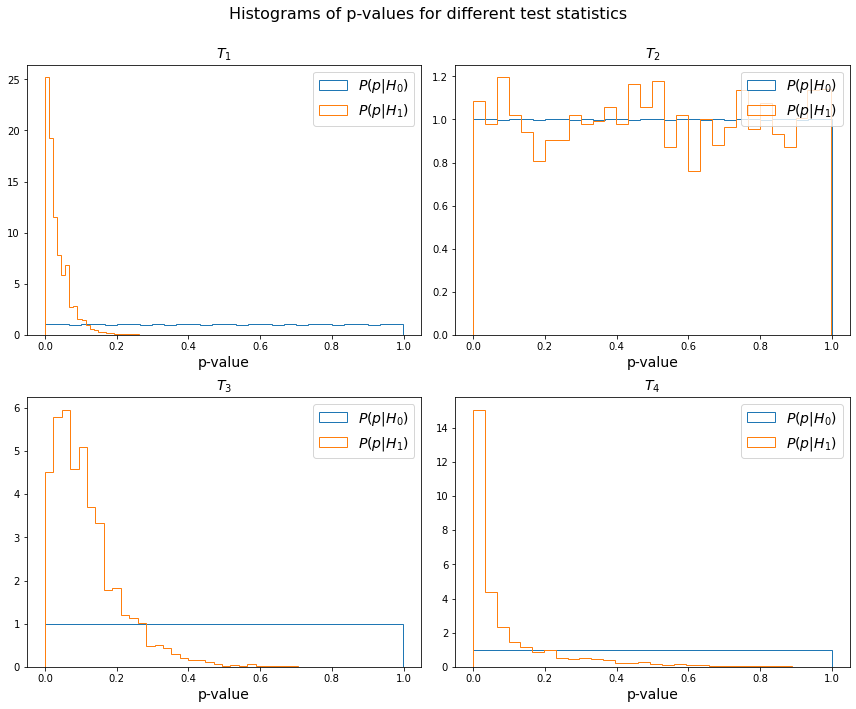

In [29]:
P10 = [p_value(T1, X, T1_sampleH0) for X in sample_H0]
P11 = [p_value(T1, X, T1_sampleH0) for X in sample_H1]
P20 = [p_value(T2, X, T2_sampleH0) for X in sample_H0]
P21 = [p_value(T2, X, T2_sampleH0) for X in sample_H1]
P30 = [p_value(T3, X, T3_sampleH0) for X in sample_H0]
P31 = [p_value(T3, X, T3_sampleH0) for X in sample_H1]
P40 = [p_value(T4, X, T4_sampleH0) for X in sample_H0]
P41 = [p_value(T4, X, T4_sampleH0) for X in sample_H1]

# Create a 2x2 subplot
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot P10 and P11 (for T1) on the first subplot (axes[0, 0])
axes[0, 0].hist(P10, bins=30, histtype='step', density=True, label=r'$P(p | H_0)$')
axes[0, 0].hist(P11, bins=30, histtype='step', density=True, label=r'$P(p | H_1)$')
axes[0, 0].set_title(r'$T_1$', fontsize=14)
axes[0, 0].set_xlabel('p-value', fontsize=14)
axes[0, 0].legend(fontsize=14)

# Plot P20 and P21 (for T2) on the second subplot (axes[0, 1])
axes[0, 1].hist(P20, bins=30, histtype='step', density=True, label=r'$P(p | H_0)$')
axes[0, 1].hist(P21, bins=30, histtype='step', density=True, label=r'$P(p | H_1)$')
axes[0, 1].set_title(r'$T_2$', fontsize=14)
axes[0, 1].set_xlabel('p-value', fontsize=14)
axes[0, 1].legend(fontsize=14)

# Plot P30 and P31 (for T3) on the third subplot (axes[1, 0])
axes[1, 0].hist(P30, bins=30, histtype='step', density=True, label=r'$P(p | H_0)$')
axes[1, 0].hist(P31, bins=30, histtype='step', density=True, label=r'$P(p | H_1)$')
axes[1, 0].set_title(r'$T_3$', fontsize=14)
axes[1, 0].set_xlabel('p-value', fontsize=14)
axes[1, 0].legend(fontsize=14)

# Plot P40 and P41 (for T4) on the fourth subplot (axes[1, 1])
axes[1, 1].hist(P40, bins=30, histtype='step', density=True, label=r'$P(p | H_0)$')
axes[1, 1].hist(P41, bins=30, histtype='step', density=True, label=r'$P(p | H_1)$')
axes[1, 1].set_title(r'$T_4$', fontsize=14)
axes[1, 1].set_xlabel('p-value', fontsize=14)
axes[1, 1].legend(fontsize=14)

# Set overall figure title and adjust layout for better spacing
fig.suptitle('Histograms of p-values for different test statistics', fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.9)  # To make space for the overall title

# Show the plot
plt.show()


## 3. Exercise: Pearson's $\chi^2$-Test

### 3.1 Load the file `SPY_close_price.csv` into your working file (Python, Jupyter Notebook). Each row corresponds to the closing price of a day in the stock market for SPY. Calculate the relative change in price with respect to the previous day and make a histogram to visualize the data (the daily change or return of SPY).

### 3.2 Fit a Gaussian distribution to the data, i.e. estimate the parameters μ, $σ^2$ (e.g. via MLE) assuming the data is normally distributed. This will be our null-hypothesis $H_0$ we want to reject or not. Plot this Gaussian in the histogram from before for comparison.

n_data = 8009
mean = 0.04657047019047401
std = 1.1731489372075548


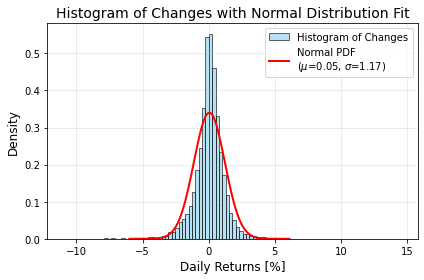

In [30]:
# Upload data
data = pd.read_csv("SPY_close_price.csv")
data = data["Close"]

# Construct the relative change of the price in %
changes = 100*np.diff(data)/data[:-1].to_numpy()

# Total number of observations, returns. Note that this is the number of days - 1
n_data = len(changes)

# Compute the MLE of a normal distribution
m = changes.mean()
sigma = changes.std()

print(f"n_data = {n_data}")
print(f"mean = {m}")
print(f"std = {sigma}")

plt.hist(changes, bins=100, density=True, alpha=0.6, color='skyblue', edgecolor='black', label='Histogram of Changes')

# Add the normal distribution curve
X = np.linspace(-6, 6, 200)
plt.plot(X, sp.stats.norm.pdf(X, loc=m, scale=sigma), color='red', lw=2, label=f'Normal PDF\n($\mu$={m:.2f}, $\sigma$={sigma:.2f})')

plt.xlabel('Daily Returns [%]', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.title('Histogram of Changes with Normal Distribution Fit', fontsize=14)
plt.legend(loc='upper right', fontsize=10)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

### 3.3 We need to bin the data into ${O_i}$

In [31]:
hist, bin_edges = np.histogram(changes, bins=np.concatenate(([-100], np.linspace(-3.5, 3.5, 21), [100])))
hist, bin_edges

(array([  62,   24,   42,   62,   98,  145,  199,  309,  539,  778, 1365,
        1564, 1097,  686,  416,  248,  143,   77,   40,   28,   30,   57]),
 array([-100.  ,   -3.5 ,   -3.15,   -2.8 ,   -2.45,   -2.1 ,   -1.75,
          -1.4 ,   -1.05,   -0.7 ,   -0.35,    0.  ,    0.35,    0.7 ,
           1.05,    1.4 ,    1.75,    2.1 ,    2.45,    2.8 ,    3.15,
           3.5 ,  100.  ]))

### 3.4  Now determine the probabilities $p_i$ for an observation (the daily change of SPY) to be in the $i^\text{th}$-bin, assuming the null-hypothesis $H_0$.

In [32]:
# The probabilities p_i are just the area of the bin under the curve of H0
P =  np.diff(sp.stats.norm.cdf(bin_edges, loc=m, scale=sigma))
E = P * n_data
# We now check if the condition E_i > 5 is fulfilled.
P, E

(array([0.00125091, 0.00196632, 0.00440674, 0.0090407 , 0.01697892,
        0.02919062, 0.0459413 , 0.06618977, 0.08729857, 0.10540293,
        0.11650058, 0.1178782 , 0.10918652, 0.09258369, 0.07186698,
        0.0510685 , 0.0332204 , 0.0197826 , 0.01078419, 0.00538166,
        0.00245848, 0.00162143]),
 array([ 10.01856599,  15.74827966,  35.2935773 ,  72.40693221,
        135.98414594, 233.78768352, 367.94384756, 530.11387047,
        699.17423397, 844.17208934, 933.053117  , 944.08654248,
        874.47487479, 741.50273932, 575.58260326, 409.00761303,
        266.06214948, 158.43885318,  86.37058946,  43.10167761,
         19.68996108,  12.98605335]))

### 3.5 Now compute $\chi^2_{\text{Pearson}}$ and the p-value, given that our statistic is distributed according to $\chi^2_{k-1}$ under $H_0$, i.e. $P(\chi^2_{\text{Pearson}}|H_0) \sim \chi^2_{k-1}$. Can we reject $H_0$?

In [33]:
# Define the Pearson's chi2 test statistic
def chi2_stat(hist):
    return ((hist - E)**2 / E).sum()

chi2_person = chi2_stat(hist)
print(f"chi2 = {chi2_person}")

# The number of degrees of freedom (dof)
dof = len(hist) - 1
print(f"dof = {dof}")
# Compute the p-value
p_value = 1 - sp.stats.chi2.cdf(chi2_person, dof)
print(f"p-value = {p_value}")
print("The p-value is so small that it is numerically 0. We therefore reject H0.")

chi2 = 1591.7775905182627
dof = 21
p-value = 0.0
The p-value is so small that it is numerically 0. We therefore reject H0.


### 3.6 Verify via MC sampling that indeed $P(χ^2_{Pearson}|H_0) ∼ χ^2_{k−1}$.

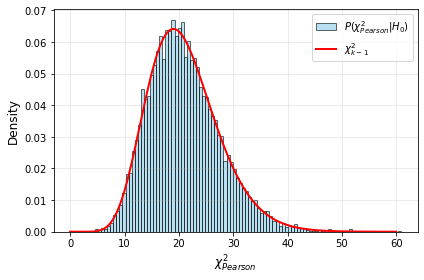

In [34]:
# Simulate N_samples samples as the real one
N_samples = 10_000
Samples = [np.histogram(sp.stats.norm.rvs(loc=m, scale=sigma, size=n_data), bins=bin_edges)[0] for _ in range(N_samples)]

# For each sample compute the Pearson's chi2 statistic
CHISQ = [chi2_stat(hist) for hist in Samples]

# Plot the retults as a histogram
plt.hist(CHISQ, bins=100, density=True, alpha=0.6, color='skyblue', edgecolor='black', label=r'$P(χ^2_{Pearson}|H_0)$')

# Plot the chi2-distr.
X = np.linspace(0, 60, 200)
plt.plot(X, sp.stats.chi2.pdf(X, df=dof), color='red', lw=2, label=r'$\chi^2_{k-1}$')

plt.xlabel(r'$χ^2_{Pearson}$', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend(loc='upper right', fontsize=10)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()